In [6]:
""" Experiment Settings """
depth_tree, depth_query = 5, 5
threshold_size = 100
times = 10
flag = True
res = []

In [7]:
""" Libraries """
import json
import numpy as np
import pandas as pd
import psycopg2
from matplotlib import pyplot as plt

import nbimporter
from Core import Ranges, nDTree, tree_shape_relation, draw_lines, draw_box, experiment_execution

In [78]:
""" Database Connection """
conn_params = "dbname='trajectory' user='gpadmin' host='192.168.59.101' password='1234' port=5432"
conn = psycopg2.connect(conn_params)
cur = conn.cursor()

In [79]:
""" Experiment Preparation: create traj table """
sql_traj_table = """
DROP EXTERNAL TABLE IF EXISTS traj_external;
CREATE READABLE EXTERNAL TABLE traj_external (
    indexing_key INTEGER,
    state SMALLINT,
    geometry GEOMETRY(LINESTRINGZ),
    taxiid BIGINT,
    distributing_key INTEGER
    )
    LOCATION ('gpfdist://192.168.59.101:8081/data_{}.csv')
    FORMAT 'csv' (HEADER)
    LOG ERRORS SEGMENT REJECT LIMIT 50 ROWS;

DROP TABLE IF EXISTS traj;
CREATE TABLE traj
(
    indexing_key     INTEGER,
    state            SMALLINT,
    geometry         GEOMETRY(LINESTRINGZ),
    taxiid           BIGINT,
    distributing_key INTEGER
);

INSERT INTO traj (indexing_key, state, geometry, taxiid, distributing_key)
SELECT indexing_key, state, geometry, taxiid, distributing_key
FROM traj_external;

DROP TABLE IF EXISTS traj_dist;
CREATE TABLE traj_dist
(
    indexing_key     INTEGER,
    state            SMALLINT,
    geometry         GEOMETRY(LINESTRINGZ),
    taxiid           BIGINT,
    distributing_key INTEGER
) DISTRIBUTED BY (distributing_key);

INSERT INTO traj_dist (indexing_key, state, geometry, taxiid, distributing_key)
SELECT indexing_key, state, geometry, taxiid, distributing_key
FROM traj;
""".format(depth_tree)

cur.execute(sql_traj_table)
conn.commit()

In [80]:
""" Experiment Preparation: create traj indexing """
sql_traj_index = """
DROP INDEX IF EXISTS traj_index_indexing_key;
CREATE INDEX traj_index_indexing_key ON traj USING btree (indexing_key);
DROP INDEX IF EXISTS traj_index_taxiid;
CREATE INDEX traj_index_taxiid ON traj USING btree (taxiid);
DROP INDEX IF EXISTS traj_index_state;
CREATE INDEX traj_index_state ON traj USING bitmap (state);
DROP INDEX IF EXISTS traj_dist_index_indexing_key;
CREATE INDEX traj_dist_index_indexing_key ON traj_dist USING btree (indexing_key);
DROP INDEX IF EXISTS traj_dist_index_taxiid;
CREATE INDEX traj_dist_index_taxiid ON traj_dist USING btree (taxiid);
DROP INDEX IF EXISTS traj_dist_index_state;
CREATE INDEX traj_dist_index_state ON traj_dist USING bitmap (state);
 """

cur.execute(sql_traj_index)
conn.commit()

In [81]:
""" Experiment Preparation: create taxi table """
sql_taxi_table = """DROP TABLE IF EXISTS taxi_table;
CREATE TABLE taxi_table
(
    taxiid BIGINT
);

INSERT INTO taxi_table (taxiid)
SELECT DISTINCT taxiid
FROM traj
WHERE taxiid IS NOT NULL
LIMIT 100;
"""

cur.execute(sql_taxi_table)
conn.commit()

In [82]:
""" Experiment 4-a """
sql_experiment_4_a = """
SELECT st_astext(traj.geometry) AS geometry, traj.state
FROM traj,
     taxi_table
WHERE traj.taxiid = taxi_table.taxiid;
"""

timings = []
print("experiment 4-a")
records = experiment_execution(times, timings, sql_experiment_4_a, cur, flag)
print("timings:", timings)
print("median:", np.median(timings))
res.append(np.median(timings))

experiment 4-a


100%|██████████| 10/10 [00:45<00:00,  4.51s/it]

timings: [5.022707462310791, 4.279371976852417, 4.50255823135376, 4.716436147689819, 4.4948999881744385, 4.24890923500061, 4.055376768112183, 4.482744455337524, 5.200610876083374, 4.08509373664856]
median: 4.4888222217559814


In [83]:
""" Visualization 4-a """
columns = [desc[0] for desc in cur.description]
df = pd.DataFrame(records, columns=columns)
#draw_lines(df, "t4-a")

In [84]:
""" Experiment 4-b """
sql_experiment_4_b = """
SELECT st_astext(traj.geometry) AS geometry, traj.state
FROM traj,
     taxi_table
WHERE traj.taxiid = taxi_table.taxiid
  AND traj.state = 1;
"""

timings = []
print("experiment 4-b")
records = experiment_execution(times, timings, sql_experiment_4_b, cur, flag)
print("timings:", timings)
print("median:", np.median(timings))
res.append(np.median(timings))

experiment 4-b


100%|██████████| 10/10 [00:14<00:00,  1.46s/it]

timings: [1.424849271774292, 1.4700043201446533, 1.5290913581848145, 1.4373230934143066, 1.5545854568481445, 1.482288122177124, 1.384533405303955, 1.3099563121795654, 1.3703334331512451, 1.6132583618164062]
median: 1.45366370677948


In [85]:
""" Visualization 4-b """
columns = [desc[0] for desc in cur.description]
df = pd.DataFrame(records, columns=columns)
#draw_lines(df, "t4-b")

In [86]:
""" Experiment Preparation: read parameters """
with open("para.json", "r") as json_file:
    para = json.load(json_file)
fold_para = para["fold_para"]
with open("{}/para_{}.json".format(fold_para, depth_tree), "r") as json_file:
    para = json.load(json_file)

dist = para["dist"]
x_scl = para["x_scl"]
y_scl = para["y_scl"]
t_scl = para["t_scl"]

{'min': [0.7, 0.7, 0.1], 'max': [0.9, 0.9, 0.9]}


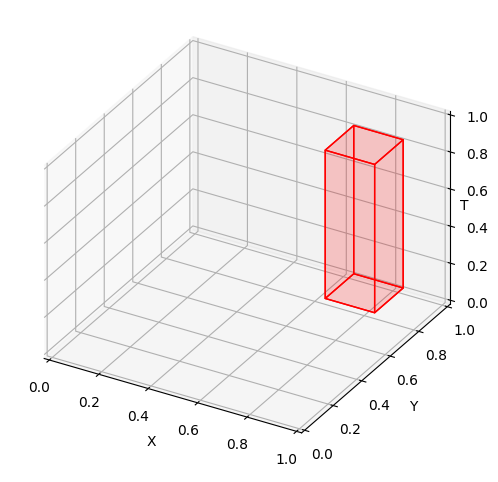

{'min': [0.1, 0.1, 0.2], 'max': [0.9, 0.5, 0.3]}


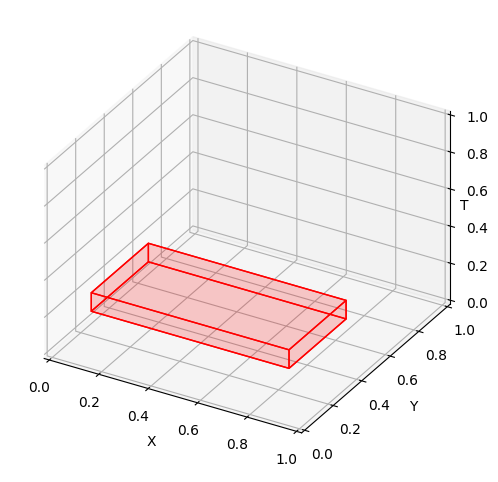

{'min': [0.1, 0.1, 0.1], 'max': [0.41747999999999996, 0.41747999999999996, 0.41747999999999996]}


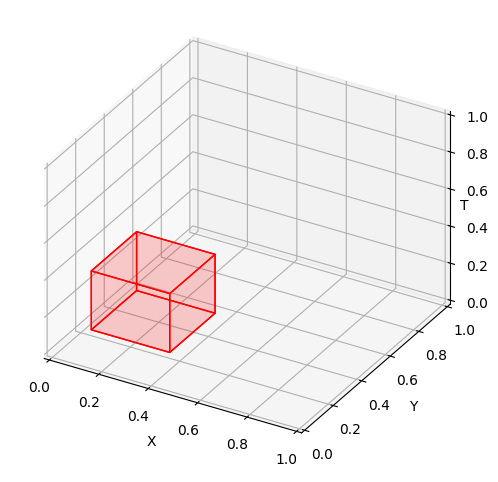

contained, continue 0 32767
outside 0 4095
outside 4096 8191
outside 8192 12287
outside 12288 16383
outside 16384 20479
outside 20480 24575
intersected, continue 24576 28671
intersected, continue 24576 25087
outside 24576 24639
outside 24640 24703
outside 24832 24895
outside 24896 24959
intersected, stop 24960 25023
intersected, stop 25024 25087
intersected, continue 25088 25599
outside 25088 25151
outside 25152 25215
outside 25216 25279
outside 25280 25343
outside 25344 25407
outside 25408 25471
intersected, stop 25472 25535
intersected, stop 25536 25599
intersected, continue 25600 26111
outside 25664 25727
outside 25728 25791
outside 25792 25855
intersected, stop 25856 25919
intersected, stop 25920 25983
intersected, stop 25984 26047
intersected, stop 26048 26111
intersected, continue 26112 26623
outside 26112 26175
outside 26176 26239
outside 26240 26303
outside 26304 26367
intersected, stop 26368 26431
intersected, stop 26432 26495
intersected, stop 26496 26559
intersected, stop 26

In [87]:
""" Experiment Preparation: calculate ranges """

index_scale = 2 ** depth_tree
queryShape_c = {"min": [0.7, 0.7, 0.1], "max": [0.9, 0.9, 0.9]}  # needle
print(queryShape_c)
draw_box(queryShape_c, "t4-c-needle")
queryShape_d = {"min": [0.1, 0.1, 0.2], "max": [0.9, 0.5, 0.3]}  # slice
print(queryShape_d)
draw_box(queryShape_d, "t4-d-slice")
queryShape_e = {"min": [0.1, 0.1, 0.1], "max": [0.41747999999999996, 0.41747999999999996, 0.41747999999999996]}  # dice
print(queryShape_e)
draw_box(queryShape_e, "t4-e-dice")
queryShape_c["min"] = [coord * index_scale for coord in queryShape_c["min"]]
queryShape_c["max"] = [coord * index_scale for coord in queryShape_c["max"]]
queryShape_d["min"] = [coord * index_scale for coord in queryShape_d["min"]]
queryShape_d["max"] = [coord * index_scale for coord in queryShape_d["max"]]
queryShape_e["min"] = [coord * index_scale for coord in queryShape_e["min"]]
queryShape_e["max"] = [coord * index_scale for coord in queryShape_e["max"]]
# initialize tree
tree = nDTree(depth_tree, dist, threshold_size)
# calculate ranges
values_c = tree.shapeQuery(queryShape_c, depth_query, tree_shape_relation)
values_d = tree.shapeQuery(queryShape_d, depth_query, tree_shape_relation)
values_e = tree.shapeQuery(queryShape_e, depth_query, tree_shape_relation)
# initialize ranges (do clean merge)
ranges_merged_c = Ranges(values_c)
ranges_merged_d = Ranges(values_d)
ranges_merged_e = Ranges(values_e)
# only the relevant ranges
ranges_c = [(range[0], range[1]) for range in ranges_merged_c.rangeList() if range[2] == 1 or range[2] == 0]
ranges_d = [(range[0], range[1]) for range in ranges_merged_d.rangeList() if range[2] == 1 or range[2] == 0]
ranges_e = [(range[0], range[1]) for range in ranges_merged_e.rangeList() if range[2] == 1 or range[2] == 0]
# create query condition
condition_c = ' OR '.join(['(%s <= indexing_key AND indexing_key <= %s )' % (r[0], r[1]) for r in ranges_c])
condition_d = ' OR '.join(['(%s <= indexing_key AND indexing_key <= %s )' % (r[0], r[1]) for r in ranges_d])
condition_e = ' OR '.join(['(%s <= indexing_key AND indexing_key <= %s )' % (r[0], r[1]) for r in ranges_e])

In [88]:
""" Experiment 4-c """
sql_experiment_4_c = """
SELECT st_astext(geometry) AS geometry, state
FROM traj
WHERE ({})
  AND (geometry IS NOT NULL);
""".format(condition_c)

timings = []
print("experiment 4-c")
records = experiment_execution(times, timings, sql_experiment_4_c, cur, flag)
print("timings:", timings)
print("median:", np.median(timings))
res.append(np.median(timings))

experiment 4-c


100%|██████████| 10/10 [00:21<00:00,  2.11s/it]

timings: [2.5499634742736816, 1.9515857696533203, 2.0014848709106445, 2.224268913269043, 2.205934762954712, 2.3388960361480713, 2.0105040073394775, 1.8320777416229248, 2.0392611026763916, 1.9288251399993896]
median: 2.0248825550079346


In [89]:
""" Visualization 4-c """
columns = [desc[0] for desc in cur.description]
df = pd.DataFrame(records, columns=columns)
#draw_lines(df, "t4-c")

In [90]:
""" Experiment 4-d """
sql_experiment_4_d = """
SELECT st_astext(geometry) AS geometry, state
FROM traj
WHERE ({})
  AND (geometry IS NOT NULL);
""".format(condition_d)

timings = []
print("experiment 4-d")
records = experiment_execution(times, timings, sql_experiment_4_d, cur, flag)
print("timings:", timings)
print("median:", np.median(timings))
res.append(np.median(timings))

experiment 4-d


100%|██████████| 10/10 [02:33<00:00, 15.37s/it]

timings: [15.408228158950806, 16.39258909225464, 16.048916816711426, 14.285718202590942, 15.355974197387695, 14.552903175354004, 16.03635811805725, 15.142207145690918, 15.102580785751343, 15.3628671169281]
median: 15.359420657157898


In [91]:
""" Visualization 4-d """
columns = [desc[0] for desc in cur.description]
df = pd.DataFrame(records, columns=columns)
#draw_lines(df, "t4-d")

In [92]:
""" Experiment 4-e """
sql_experiment_4_e = """
SELECT st_astext(geometry) AS geometry, state
FROM traj
WHERE ({})
  AND (geometry IS NOT NULL);
""".format(condition_e)

timings = []
print("experiment 4-e")
records = experiment_execution(times, timings, sql_experiment_4_e, cur, flag)
print("timings:", timings)
print("median:", np.median(timings))
res.append(np.median(timings))

experiment 4-e


100%|██████████| 10/10 [01:23<00:00,  8.33s/it]

timings: [8.076849222183228, 8.040711641311646, 7.99652624130249, 9.0244300365448, 8.661916494369507, 8.57891583442688, 8.685877799987793, 7.702243089675903, 7.94172215461731, 8.601444959640503]
median: 8.327882528305054


In [93]:
""" Visualization 4-e """
columns = [desc[0] for desc in cur.description]
df = pd.DataFrame(records, columns=columns)
#draw_lines(df, "t4-e")

In [94]:
cur.close()
conn.close()

In [95]:
print(res)

[4.4888222217559814, 1.45366370677948, 2.0248825550079346, 15.359420657157898, 8.327882528305054]


In [8]:
num_node = [1, 2, 3, 4]
res_1 = [4.4888222217559814, 1.45366370677948, 2.0248825550079346, 15.359420657157898, 8.327882528305054]
res_2 = [2.370740532875061, 0.8471623659133911, 1.256090760231018, 8.385926961898804, 4.917688965797424]
res_3 = [1.6017491817474365, 0.5573853254318237, 0.8825836181640625, 5.925011873245239, 3.353540062904358]
res_4 = [1.2340415716171265, 0.4918555021286011, 0.7036291360855103, 4.643234491348267, 2.7545539140701294]

In [9]:
t_4_a = []
t_4_b = []
t_4_c = []
t_4_d = []
t_4_e = []

all_res = [res_1, res_2, res_3, res_4]

for res in all_res:
    t_4_a.append(res[0])
    t_4_b.append(res[1])
    t_4_c.append(res[2])
    t_4_d.append(res[3])
    t_4_e.append(res[4])

In [10]:
print([round(val, 2) for val in t_4_a])
print([round(val, 2) for val in t_4_b])
print([round(val, 2) for val in t_4_c])
print([round(val, 2) for val in t_4_d])
print([round(val, 2) for val in t_4_e])

[4.49, 2.37, 1.6, 1.23]
[1.45, 0.85, 0.56, 0.49]
[2.02, 1.26, 0.88, 0.7]
[15.36, 8.39, 5.93, 4.64]
[8.33, 4.92, 3.35, 2.75]


In [11]:
a = t_4_a[0]
b = t_4_b[0]
c = t_4_c[0]
d = t_4_d[0]
e = t_4_e[0]
t_4_a = [a / val for val in t_4_a]
t_4_b = [b / val for val in t_4_b]
t_4_c = [c / val for val in t_4_c]
t_4_d = [d / val for val in t_4_d]
t_4_e = [e / val for val in t_4_e]

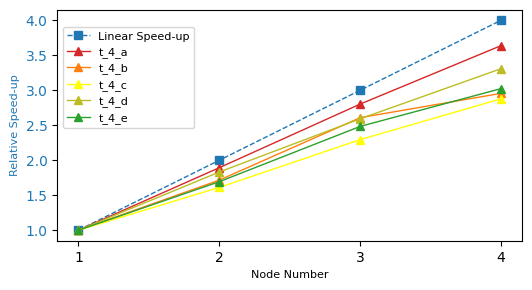

In [12]:
fig, ax1 = plt.subplots(figsize=(6, 3))

ax1.set_xlabel('Node Number', fontdict={"fontsize": 8})
ax1.set_ylabel('Relative Speed-up', color='tab:blue', fontdict={"fontsize": 8})
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.plot(num_node, num_node, label='Linear Speed-up', color='tab:blue', marker='s', linewidth=1, linestyle='--')
ax1.plot(num_node, t_4_a, label='t_4_a', color='tab:red', marker='^', linewidth=1)
ax1.plot(num_node, t_4_b, label='t_4_b', color='tab:orange', marker='^', linewidth=1)
ax1.plot(num_node, t_4_c, label='t_4_c', color='yellow', marker='^', linewidth=1)
ax1.plot(num_node, t_4_d, label='t_4_d', color='tab:olive', marker='^', linewidth=1)
ax1.plot(num_node, t_4_e, label='t_4_e', color='tab:green', marker='^', linewidth=1)
ax1.legend(fontsize=8, loc='upper left', bbox_to_anchor=(0, 0.95))
plt.xticks(num_node)
fig.savefig("figs/speedup.pdf", bbox_inches='tight')
plt.show()